In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import pearsonr
from scipy import stats
import warnings
from scipy.signal import argrelextrema
from cydets.algorithm import detect_cycles
import os 
import openpyxl

warnings.filterwarnings('ignore')

## Load Data

In [131]:
curr_path = os.getcwd()
input_path = os.path.join(curr_path,'S&P500-EPS.xlsx')
df = pd.read_excel(
    input_path,
    engine='openpyxl',
    header=None,
    skiprows = 1
)

df.columns = ['Date', 'SP500-PE', 'SP500-Price', 'SP500-EPS', 'SP500-Index']
df.dropna(axis=0, how='any', inplace=True)

df['EPS-GR'] = df['SP500-EPS'].pct_change(1) * 100

In [123]:
df.head()

,Date,SP500-PE,SP500-Price,SP500-EPS,SP500-Index,EPS-GR
0,2021-03-01,41.54,3910.51,94.138421,1603.291856,NaN
1,2021-02-01,41.26,3883.43,94.120940,1602.994143,-0.018569
2,2021-01-01,40.30,3793.75,94.137717,1603.279871,0.017825
3,2020-12-01,39.26,3695.31,94.124045,1603.047015,-0.014524
4,2020-11-01,37.16,3548.99,95.505651,1626.577454,1.467857


## Find Peak and Trough

In [5]:
# find the local min and local max
ilocs_min = argrelextrema(df['SP500-Index'].values, np.less_equal, mode = 'wrap', order = 12)[0]
ilocs_max = argrelextrema(df['SP500-Index'].values, np.greater_equal, mode = 'wrap', order = 12)[0]

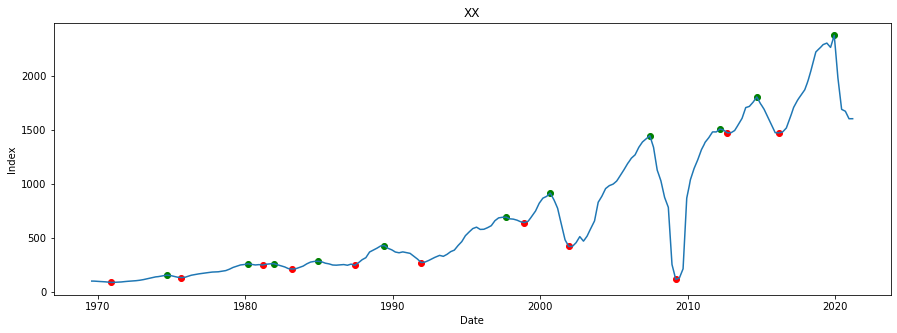

In [6]:
# plot 
y = df['SP500-Index']
x = df['Date']
plt.figure(figsize=(15,5))
plt.plot(x, y)
plt.scatter(df.iloc[ilocs_min]['Date'], df.iloc[ilocs_min]['SP500-Index'], color = 'red')
plt.scatter(df.iloc[ilocs_max]['Date'], df.iloc[ilocs_max]['SP500-Index'], color ='green')
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('XX')
plt.show()
#sns.lineplot(df['Date'], df['SP500-Index'])

In [7]:
# get the anormal event date
peak_date = df.iloc[ilocs_min]['Date']
trough_date = df.iloc[ilocs_max]['Date']

## Find Cycle(Short term contraction, Long term growth, irregular)

In [64]:
cycles = detect_cycles(df['SP500-Index'] )

# filter out distictive business cycle, depth >= 0.025
cycles_deep = cycles.loc[cycles['doc'] >= 0.025]
cycles_deep

,t_start,t_end,t_minimum,doc,duration
3,21,78,60,0.145333,57
7,112,165,144,0.581167,53
9,165,246,231,0.215935,81
14,306,381,351,0.068804,75


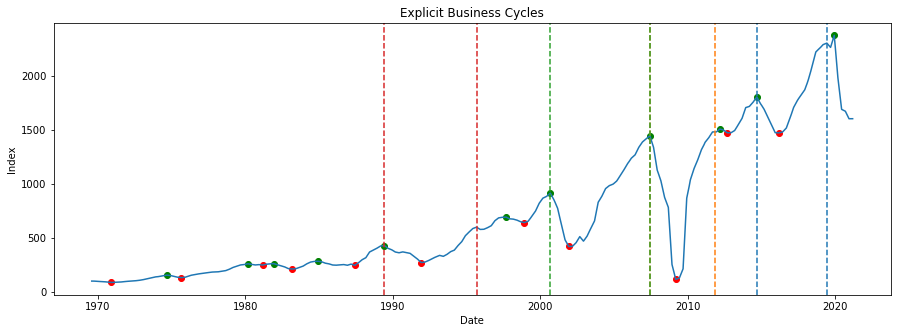

In [128]:
# 
y = df['SP500-Index']
x = df['Date']
color_l = sns.color_palette("tab10", cycles_deep.shape[0])

plt.figure(figsize=(15,5))
plt.plot(x, y)
color_pointer = 0
for index, row in cycles_deep.iterrows():
    x_start = row['t_start']
    x_end = row['t_end']
    plt.axvline(df['Date'].loc[x_start], color=color_l[color_pointer], linestyle='--')
    plt.axvline(df['Date'].loc[x_end], color=color_l[color_pointer], linestyle='--')
    color_pointer +=1 
plt.scatter(df.iloc[ilocs_min]['Date'], df.iloc[ilocs_min]['SP500-Index'], color = 'red')
plt.scatter(df.iloc[ilocs_max]['Date'], df.iloc[ilocs_max]['SP500-Index'], color ='green')
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Explicit Business Cycles')
plt.show()


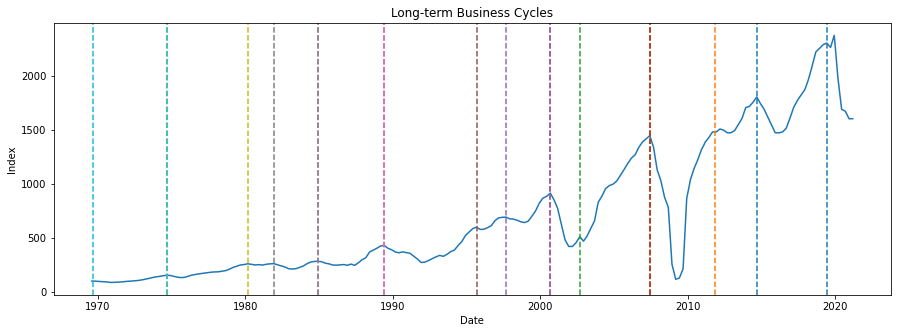

In [127]:
cycles_long = cycles.loc[cycles['duration'] >= 36]

y = df['SP500-Index']
x = df['Date']
color_l = sns.color_palette("tab10", cycles_long.shape[0])

plt.figure(figsize=(15,5))
plt.plot(x, y)
color_pointer = 0
for index, row in cycles_long.iterrows():
    x_start = row['t_start']
    x_end = row['t_end']
    plt.axvline(df['Date'].loc[x_start], color=color_l[color_pointer], linestyle='--')
    plt.axvline(df['Date'].loc[x_end], color=color_l[color_pointer], linestyle='--')
    color_pointer +=1 

plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Long-term Business Cycles')
plt.show()


In [110]:
# import us gdp data
curr_path = os.getcwd()
input_path = os.path.join(curr_path,'GDP.xlsx')
gdp_df = pd.read_excel(
    input_path,
    engine='openpyxl',
    header=None,
)

gdp_df.columns = ['Date', 'GDP']
gdp_df.dropna(axis=0, how='any', inplace=True)

# calculate growth rate
gdp_df['Growth Rate'] = gdp_df['GDP'].pct_change(1) * 100


In [107]:
gdp_df.head(5)

,Date,GDP,Grow Rate
0,1969-07-01,1029.956,NaN
1,1969-10-01,1038.147,0.795277
2,1970-01-01,1051.200,1.257336
3,1970-04-01,1067.375,1.538718
4,1970-07-01,1086.059,1.750463


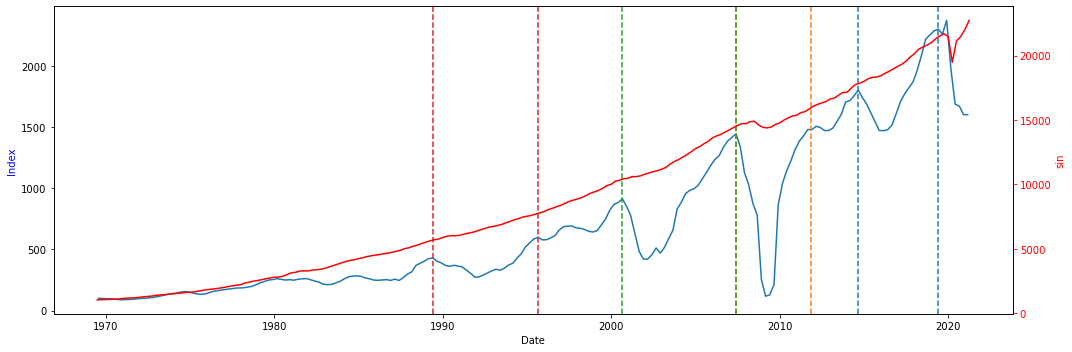

In [129]:
y = df['SP500-Index']
x = df['Date']
color_l = sns.color_palette("tab10", cycles_deep.shape[0])

fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot(x, y)
color_pointer = 0
for index, row in cycles_deep.iterrows():
    x_start = row['t_start']
    x_end = row['t_end']
    ax1.axvline(df['Date'].loc[x_start], color=color_l[color_pointer], linestyle='--')
    ax1.axvline(df['Date'].loc[x_end], color=color_l[color_pointer], linestyle='--')
    color_pointer +=1 

ax1.set_xlabel('Date')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Index', color='b')

ax2 = ax1.twinx()
ax2.plot(gdp_df['Date'], gdp_df['GDP'], color='red')
ax2.set_ylabel('sin', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()



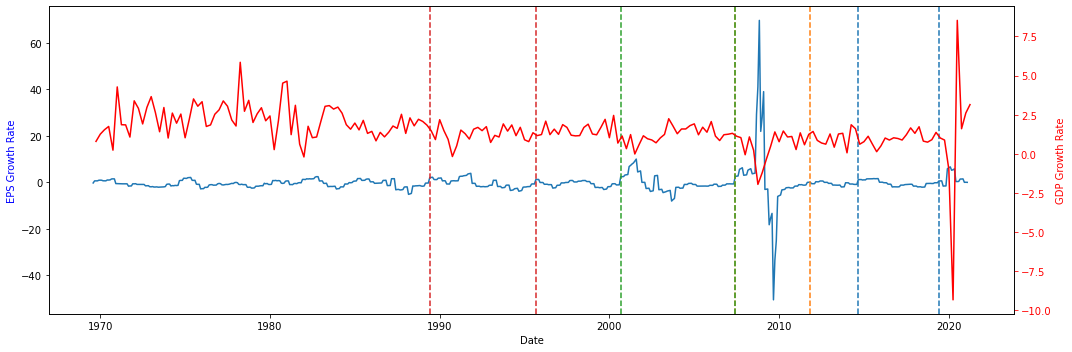

In [130]:
y = df['EPS-GR']
x = df['Date']
color_l = sns.color_palette("tab10", cycles_deep.shape[0])

fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot(x, y)
color_pointer = 0
for index, row in cycles_deep.iterrows():
    x_start = row['t_start']
    x_end = row['t_end']
    ax1.axvline(df['Date'].loc[x_start], color=color_l[color_pointer], linestyle='--')
    ax1.axvline(df['Date'].loc[x_end], color=color_l[color_pointer], linestyle='--')
    color_pointer +=1 

ax1.set_xlabel('Date')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('EPS Growth Rate', color='b')

ax2 = ax1.twinx()
ax2.plot(gdp_df['Date'], gdp_df['Growth Rate'], color='red')
ax2.set_ylabel('GDP Growth Rate', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()